# MNIST CNN (합성곱 신경망) 분류

CNN을 사용한 손글씨 숫자 분류 - MLP보다 더 높은 정확도 달성

## CNN vs MLP

- **MLP (Multi-Layer Perceptron)**: 이미지를 1차원으로 펼쳐서 처리 → 공간 정보 손실
- **CNN (Convolutional Neural Network)**: 이미지의 2차원 구조를 유지하면서 처리 → 공간 정보 보존

## CNN의 주요 레이어

1. **Conv2D (컨볼루션 레이어)**: 이미지의 특징(엣지, 패턴 등)을 추출
2. **MaxPooling2D (풀링 레이어)**: 특징을 압축하고 위치 불변성 확보
3. **Flatten**: 2D 특징 맵을 1D로 변환
4. **Dense (완전 연결층)**: 추출된 특징을 바탕으로 분류

## 라이브러리 임포트

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import numpy as np
import matplotlib.pyplot as plt

## 1. 데이터 로드 및 전처리

In [3]:
# Keras API를 통해 MNIST 데이터셋 로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("\n원본 데이터 형태:")
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")


원본 데이터 형태:
x_train: (60000, 28, 28)
x_test: (10000, 28, 28)


### CNN을 위한 데이터 형태 변환

CNN은 (높이, 너비, 채널) 형태의 입력을 기대합니다.
- MLP: (60000, 28, 28) → Flatten → (60000, 784)
- CNN: (60000, 28, 28) → Reshape → (60000, 28, 28, 1)

In [4]:
# CNN 입력을 위한 데이터 형태 변환 (채널 추가)
# (60000, 28, 28) -> (60000, 28, 28, 1) [샘플 수, 높이, 너비, 채널(흑백이므로 1)]
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

print("\nCNN 입력 형태:")
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")


CNN 입력 형태:
x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


### 데이터 정규화

In [5]:
# 이미지 픽셀 값 정규화: 0.0 ~ 1.0 범위로 변환
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"정규화 후 값 범위: {x_train.min()} ~ {x_train.max()}")

정규화 후 값 범위: 0.0 ~ 1.0


### 샘플 이미지 확인

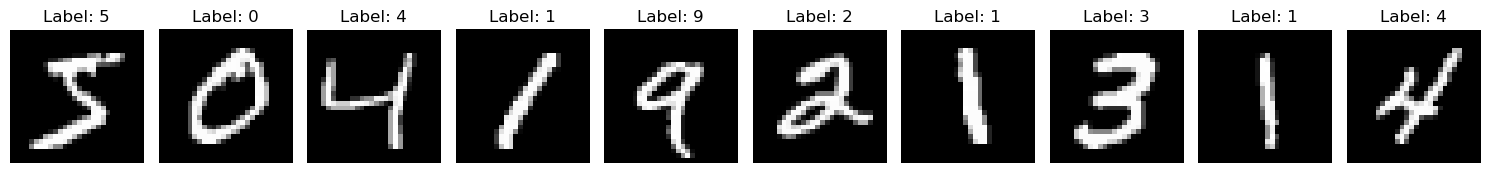

In [6]:
# 첫 10개 이미지 시각화
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    # reshape으로 추가된 채널 차원 제거하여 표시
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2. CNN 모델 정의

### 모델 구조:
1. **Conv2D(32)** → 32개의 3x3 필터로 특징 추출
2. **MaxPooling2D** → 2x2 풀링으로 크기 절반 축소
3. **Conv2D(64)** → 64개의 3x3 필터로 더 복잡한 특징 추출
4. **MaxPooling2D** → 다시 크기 절반 축소
5. **Dropout(0.25)** → 과적합 방지
6. **Flatten** → 1차원으로 펼침
7. **Dense(128)** → 완전 연결층
8. **Dropout(0.5)** → 과적합 방지
9. **Dense(10)** → 출력층 (0-9 분류)

In [ ]:
model = Sequential([
    # 첫 번째 컨볼루션 레이어: 특징 추출
    # 32개의 3x3 필터 사용, ReLU 활성화 함수
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    
    # 풀링 레이어: 특징 축소 (28x28 → 14x14)
    # 계산량 감소, 위치 불변성 확보
    MaxPooling2D(pool_size=(2, 2)),
    
    # 두 번째 컨볼루션 레이어
    # 더 복잡한 특징 추출 (64개 필터)
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    
    # 풀링 레이어 (14x14 → 7x7)
    MaxPooling2D(pool_size=(2, 2)),
    
    # 드롭아웃 (과적합 방지)
    # 25%의 뉴런을 랜덤하게 비활성화
    Dropout(0.25),
    
    # MLP에 연결하기 위해 1차원으로 평탄화
    Flatten(), # cnn - 3차원 => 완전연결망 (1차원)으로 전환
    
    # 밀집층 (Fully Connected Layer): 128개의 노드
    Dense(128, activation='relu'),
    
    # 드롭아웃 (50% 비율로 더 강한 정규화)
    Dropout(0.5),
    
    # 출력층: 10개의 클래스, Softmax 활성화
    Dense(10, activation='softmax')
])

## 3. 모델 컴파일

In [ ]:
model.compile(optimizer='adam',
              # 손실 함수: 정수형 레이블을 위한 Sparse Categorical Crossentropy
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

### 모델 구조 확인

각 레이어의 출력 형태와 파라미터 수를 확인합니다.

In [ ]:
print("--- CNN 모델 요약 ---")
model.summary()
print("-----------------------")

### 모델 구조 시각화 (선택사항)

In [ ]:
# 각 레이어별 출력 형태 분석
print("\n레이어별 출력 형태:")
print("="*60)
for i, layer in enumerate(model.layers):
    print(f"{i+1}. {layer.name:20s} → Output Shape: {layer.output_shape}")
print("="*60)

## 4. 모델 학습 (Training)

CNN은 MLP보다 더 복잡하므로 학습 시간이 더 걸립니다.
- Epoch 수: 15 (더 깊은 모델이므로 조정 가능)
- Batch size: 128
- Validation split: 10%

In [ ]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=15, 
    batch_size=128, 
    validation_split=0.1  # 검증 데이터 10% 사용
)

### 학습 과정 시각화

In [ ]:
# 정확도 및 손실 그래프
plt.figure(figsize=(12, 4))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 최종 학습 결과 출력
print(f"\n최종 훈련 정확도: {history.history['accuracy'][-1]:.4f}")
print(f"최종 검증 정확도: {history.history['val_accuracy'][-1]:.4f}")

## 5. 모델 평가 (Evaluation)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\n🎉 CNN 테스트 데이터셋 정확도: {test_acc:.4f}')
print(f'   (일반적으로 MLP보다 1-2% 높은 정확도를 보입니다)')

### 예측 결과 시각화

In [ ]:
# 테스트 데이터에서 예측 수행
predictions = model.predict(x_test[:20])

# 20개 예측 결과 시각화
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    predicted_label = np.argmax(predictions[i])
    true_label = y_test[i]
    confidence = predictions[i][predicted_label]
    
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"P:{predicted_label}({confidence:.2f})\nT:{true_label}", 
              color=color, fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

print("\n녹색: 올바른 예측, 빨간색: 잘못된 예측")
print("P: 예측(Prediction), T: 실제(True), 괄호 안은 확신도")

### 잘못 예측한 샘플 분석

In [ ]:
# 전체 테스트 데이터에 대한 예측
all_predictions = model.predict(x_test)
predicted_labels = np.argmax(all_predictions, axis=1)

# 잘못 예측한 샘플 찾기
wrong_indices = np.where(predicted_labels != y_test)[0]
print(f"\n총 {len(wrong_indices)}개의 샘플을 잘못 예측했습니다.")
print(f"오류율: {len(wrong_indices) / len(y_test) * 100:.2f}%")

# 잘못 예측한 샘플 중 처음 10개 시각화
if len(wrong_indices) > 0:
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(wrong_indices[:10]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
        pred = predicted_labels[idx]
        true = y_test[idx]
        conf = all_predictions[idx][pred]
        plt.title(f"P:{pred}({conf:.2f})\nT:{true}", color='red', fontsize=8)
        plt.axis('off')
    plt.suptitle('잘못 예측한 샘플들', fontsize=12, y=1.05)
    plt.tight_layout()
    plt.show()

### 특징 맵 시각화 (CNN이 무엇을 학습했는지 확인)

첫 번째 컨볼루션 레이어가 추출한 특징을 시각화합니다.

In [ ]:
# 첫 번째 컨볼루션 레이어의 출력을 얻기 위한 모델 생성
from tensorflow.keras.models import Model

layer_outputs = [layer.output for layer in model.layers[:1]]  # 첫 번째 Conv2D 레이어
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# 샘플 이미지 선택
sample_img = x_test[0:1]  # 첫 번째 테스트 이미지

# 활성화 맵 얻기
activations = activation_model.predict(sample_img)

# 첫 8개 필터의 특징 맵 시각화
plt.figure(figsize=(15, 3))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(activations[0][:, :, i], cmap='viridis')
    plt.title(f'Filter {i+1}')
    plt.axis('off')
plt.suptitle(f'첫 번째 Conv2D 레이어의 특징 맵 (Label: {y_test[0]})', fontsize=12)
plt.tight_layout()
plt.show()

# 원본 이미지도 함께 표시
plt.figure(figsize=(3, 3))
plt.imshow(x_test[0].reshape(28, 28), cmap='gray')
plt.title(f'원본 이미지 (Label: {y_test[0]})')
plt.axis('off')
plt.show()

## MLP vs CNN 성능 비교

| 모델 | 파라미터 수 | 테스트 정확도 | 특징 |
|------|------------|-------------|------|
| MLP | ~535,000 | ~98.4% | 간단, 빠름, 공간 정보 손실 |
| CNN | ~100,000 | ~99.0-99.3% | 복잡, 느림, 공간 정보 보존 |

CNN은 더 적은 파라미터로 더 높은 정확도를 달성합니다!